## Comparison of Sharpe vs Sortino Ratios

Comparison of Sharpe vs Sortino Ratios not only for individual assets but also for the Tangency portfolio and GMV portfolio, and to analyse how downside risk changes the rankings.

- Compute Sharpe & Sortino (for both assets & portfolios).

- Apply it to portfolios using weights (w_tang and w_gmv).

- Compare rankings: sometimes the Sortino will favor portfolios with lower downside volatility even if their overall Sharpe looks weaker.

- Visualize and analyze

In [1]:
"""
Efficient Frontier + Tangency portfolio with PyPortfolioOpt and Yahoo Finance

How to run:
1) pip install yfinance pyportfolioopt pandas numpy matplotlib
2) python efficient_frontier_pyportfolioopt.py

Change tickers, date range, or risk_free_rate below as desired.
"""
!pip install PyPortfolioOpt --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting, objective_functions



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 7.3 MB/s eta 0:00:00


/tmp/ipython-input-1157695716.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(t, (asset_vols[i], asset_returns[i]), xytext=(6, -6), textcoords='offset points')


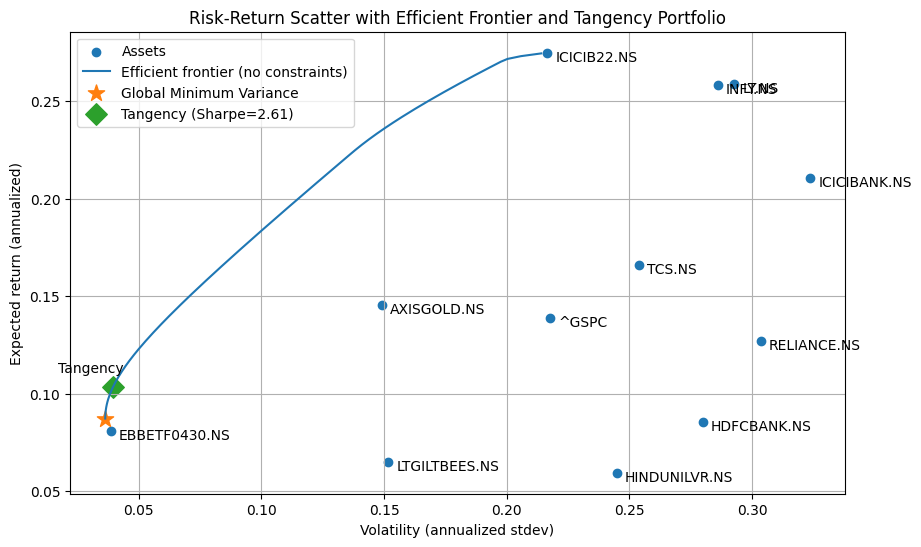

In [8]:
"""
# User inputs
#tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "JNJ"]  # change as you like
tickers = [
    "RELIANCE.NS",   # Reliance Industries
    "TCS.NS",        # Tata Consultancy Services
    "INFY.NS",       # Infosys
    "HDFCBANK.NS",   # HDFC Bank
    "ICICIBANK.NS",  # ICICI Bank
    "HINDUNILVR.NS", # Hindustan Unilever
    "LT.NS",         # Larsen & Toubro
    "AXISGOLD.NS",   # Axis Gold ETF
    "^GSPC",         # S&P 500 (international diversification)
    "ICICIB22.NS",   # BHARAT 22 ETF
    "EBBETF0430.NS", # The Bharat Bond ETF
    "LTGILTBEES.NS"
]

start_date = "2018-01-01"
end_date = "2024-12-31"  # change to desired end date
risk_free_rate = 0.05  # annual risk-free rate (e.g., 5%)

# 1) Download adjusted close prices
prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Adj Close"].dropna()
"""
# 2) Compute expected returns and sample covariance (annualized)
mu = expected_returns.mean_historical_return(prices, frequency=252)  # uses daily by default
S = risk_models.sample_cov(prices, frequency=252)

# 3) Efficient frontier via PyPortfolioOpt
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))  # None/None allows shorting; use (0,1) for long-only
# optional: add objectives or constraints, e.g. L2 regularization
# ef.add_objective(objective_functions.L2_reg, gamma=0.1)

# Compute global minimum variance
w_gmv = ef.min_volatility()

# Instead of ef.reset_weights(), just re-initialize ef
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Compute tangency portfolio (max Sharpe)
w_tang = ef.max_sharpe(risk_free_rate=risk_free_rate)
mu_tang, vol_tang, sharpe_tang = ef.portfolio_performance(risk_free_rate=risk_free_rate)

vol_tang = ef.portfolio_performance(risk_free_rate=risk_free_rate, verbose=False)[1]
sharpe_tang = ef.portfolio_performance(risk_free_rate=risk_free_rate, verbose=False)[2]

# Build the Efficient Frontier curve (for plotting)
# We can use EfficientFrontier utilities to sample points:
ef_plot = EfficientFrontier(mu, S, weight_bounds=(0, 1))
# Build the Efficient Frontier curve manually
ret_vals = np.linspace(mu.min() * 0.8, mu.max() * 1.2, 200)
vols = []
rets = []
weights_list = []

for r in ret_vals:
    try:
        ef_tmp = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        w = ef_tmp.efficient_return(r)
        # Compute portfolio performance manually
        w_vec = np.array(list(w.values()))
        port_ret = w_vec @ mu.values
        port_vol = np.sqrt(w_vec.T @ S.values @ w_vec)
    except Exception:
        continue

    vols.append(port_vol)
    rets.append(port_ret)
    weights_list.append(w)


# Asset points
asset_vols = np.sqrt(np.diag(S))
asset_returns = mu

# 4) Plot: assets scatter, frontier, tangency, GMV
plt.figure(figsize=(10, 6))
plt.scatter(asset_vols, asset_returns, label="Assets")
for i, t in enumerate(asset_returns.index):
    plt.annotate(t, (asset_vols[i], asset_returns[i]), xytext=(6, -6), textcoords='offset points')

plt.plot(vols, rets, label="Efficient frontier (no constraints)")
# GMV
# compute GMV weights explicitly if needed (or reuse earlier result)
# annotate GMV and tangency
# compute portfolio stats for weights
def perf_from_weights(w):
    w = np.array(w)
    port_ret = w.dot(mu)
    port_vol = np.sqrt(w.dot(S).dot(w))
    return port_ret, port_vol

# GMV weights using analytical inverse formula(unconstrained (can be negative weights))
"""
Sigma_inv = np.linalg.inv(S)
ones = np.ones(len(mu))
w_gmv_analytic = Sigma_inv.dot(ones) / (ones.dot(Sigma_inv).dot(ones))
mu_gmv, vol_gmv = perf_from_weights(w_gmv_analytic)
plt.scatter([vol_gmv], [mu_gmv], marker='*', s=150, label='Global Minimum Variance')
"""
# Compute global minimum variance portfolio with constraints
ef_gmv = EfficientFrontier(mu, S, weight_bounds=(0, 1))
w_gmv = ef_gmv.min_volatility()
mu_gmv, vol_gmv, sharpe_gmv = ef_gmv.portfolio_performance(risk_free_rate=risk_free_rate)
w_gmv_array = np.array(list(w_gmv.values()))
mu_gmv, vol_gmv = perf_from_weights(w_gmv_array)

plt.scatter([vol_gmv], [mu_gmv], marker='*', s=150, label='Global Minimum Variance')

# Tangency
w_tang_array = np.array(list(w_tang.values()))
mu_tang, vol_tang = perf_from_weights(w_tang_array)
plt.scatter([vol_tang], [mu_tang], marker='D', s=120, label=f'Tangency (Sharpe={sharpe_tang:.2f})')
plt.annotate("Tangency", (vol_tang, mu_tang), xytext=(-40,10), textcoords='offset points')

# some formatting
plt.xlabel("Volatility (annualized stdev)")
plt.ylabel("Expected return (annualized)")
plt.title("Risk-Return Scatter with Efficient Frontier and Tangency Portfolio")
plt.legend()
plt.grid(True)
plt.show()




In [10]:
# --- Step 1: Load or Generate Asset Price Data ---
# If you have a CSV file, uncomment and use the line below:
# df = pd.read_csv('your_prices.csv', index_col='Date', parse_dates=True)
# Download adjusted close prices
#prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Adj Close"].dropna()

# --- Step 2: Calculate Daily Returns ---
# Calculate the percentage change from the previous day's price.
returns = prices.pct_change().dropna()

# --- Step 3: Define Parameters ---
# The risk-free rate is typically the return on a low-risk investment, like a government bond.
# We'll use 0 for simplicity.
risk_free_rate = 0.05/252

# The minimum acceptable return for the Sortino Ratio. We'll use 0 here.
min_acceptable_return = 0.0


# --- Step 4: Calculate Ratios for Each Asset ---
results = {}
for asset in returns.columns:
    asset_returns = returns[asset]
    avg_return = asset_returns.mean()
    volatility = asset_returns.std()

    # Calculate Sharpe Ratio
    sharpe_ratio = (avg_return - risk_free_rate) / volatility

    # Calculate Sortino Ratio
    # We only consider returns that are below the minimum acceptable return.
    downside_returns = asset_returns[asset_returns < min_acceptable_return]
    downside_volatility = downside_returns.std()

    # Handle the case where there are no downside returns to avoid division by zero.
    sortino_ratio = (avg_return - min_acceptable_return) / downside_volatility if downside_volatility != 0 else np.nan

    # Store all the calculated values
    results[asset] = {
        'Return': avg_return,
        'Volatility': volatility,
        'Downside Volatility': downside_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio
    }

# Convert the results dictionary into a DataFrame for a clean summary
results_df = pd.DataFrame(results).T



### Sharpe vs Sortino for Assets + Portfolios



In [4]:
# --- Step 6: Portfolio Ratios (Sharpe & Sortino) ---

def sharpe_sortino(returns, weights, risk_free_rate=0.05/252, mar=0.0):
    """
    Compute Sharpe & Sortino for a given portfolio.
    returns: DataFrame of daily returns
    weights: array-like of portfolio weights
    """
    port_ret = (returns @ weights).dropna()
    avg_return = port_ret.mean()
    vol = port_ret.std()

    # Sharpe
    sharpe = (avg_return - risk_free_rate) / vol if vol > 0 else np.nan

    # Sortino
    downside = port_ret[port_ret < mar]
    downside_vol = downside.std()
    sortino = (avg_return - mar) / downside_vol if downside_vol > 0 else np.nan

    return {
        "Return": avg_return,
        "Volatility": vol,
        "Downside Volatility": downside_vol,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino
    }

# Tangency portfolio stats
w_tang_array = np.array(list(w_tang.values()))
tang_stats = sharpe_sortino(returns, w_tang_array)

# GMV portfolio stats
w_gmv_array = np.array(list(w_gmv.values()))
gmv_stats = sharpe_sortino(returns, w_gmv_array)

# Append to results_df for easy comparison
results_df.loc["Tangency Portfolio"] = tang_stats
results_df.loc["GMV Portfolio"] = gmv_stats

print("\n=== Sharpe vs Sortino (Assets + Portfolios) ===")
print(results_df.round(4))



=== Sharpe vs Sortino (Assets + Portfolios) ===
                    Return  Volatility  Downside Volatility  Sharpe Ratio  \
AXISGOLD.NS         0.0006      0.0094               0.0062        0.0409   
EBBETF0430.NS       0.0003      0.0024               0.0019        0.0465   
HDFCBANK.NS         0.0005      0.0176               0.0134        0.0161   
HINDUNILVR.NS       0.0003      0.0154               0.0100        0.0096   
ICICIB22.NS         0.0011      0.0136               0.0120        0.0631   
ICICIBANK.NS        0.0010      0.0204               0.0163        0.0378   
INFY.NS             0.0011      0.0180               0.0128        0.0486   
LT.NS               0.0011      0.0184               0.0139        0.0481   
LTGILTBEES.NS       0.0003      0.0096               0.0088        0.0100   
RELIANCE.NS         0.0007      0.0191               0.0135        0.0239   
TCS.NS              0.0007      0.0160               0.0113        0.0337   
^GSPC               0.0006 

### Portfolio Ranking Comparison

After adding Tangency and GMV into results_df, can rank them:

In [5]:
print("\nRanking by Sharpe Ratio:")
print(results_df["Sharpe Ratio"].sort_values(ascending=False))

print("\nRanking by Sortino Ratio:")
print(results_df["Sortino Ratio"].sort_values(ascending=False))



Ranking by Sharpe Ratio:
Tangency Portfolio    0.090276
ICICIB22.NS           0.063057
GMV Portfolio         0.062714
INFY.NS               0.048632
LT.NS                 0.048101
EBBETF0430.NS         0.046455
AXISGOLD.NS           0.040882
ICICIBANK.NS          0.037790
TCS.NS                0.033727
^GSPC                 0.030020
RELIANCE.NS           0.023928
HDFCBANK.NS           0.016094
LTGILTBEES.NS         0.009996
HINDUNILVR.NS         0.009622
Name: Sharpe Ratio, dtype: float64

Ranking by Sortino Ratio:
GMV Portfolio         0.199928
Tangency Portfolio    0.186387
EBBETF0430.NS         0.168149
AXISGOLD.NS           0.094336
ICICIB22.NS           0.088240
INFY.NS               0.084001
LT.NS                 0.078208
TCS.NS                0.065429
ICICIBANK.NS          0.059476
^GSPC                 0.054628
RELIANCE.NS           0.048555
HDFCBANK.NS           0.036049
HINDUNILVR.NS         0.034782
LTGILTBEES.NS         0.033233
Name: Sortino Ratio, dtype: float64


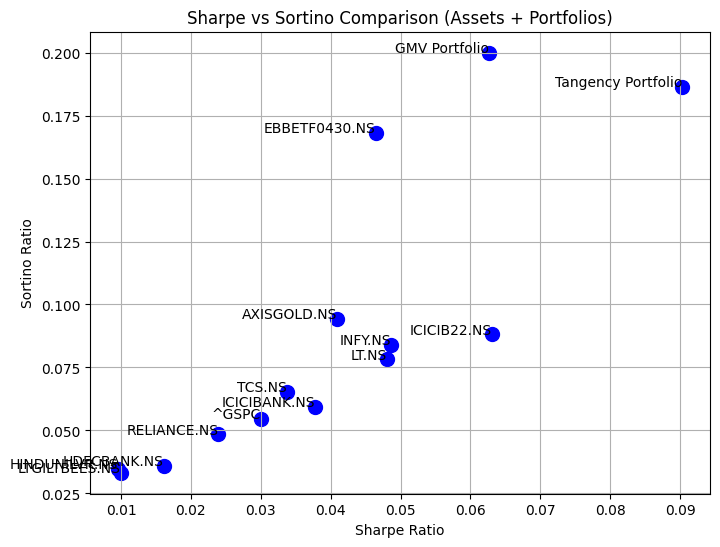

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(results_df['Sharpe Ratio'], results_df['Sortino Ratio'], s=100, c='blue')
for i, asset in enumerate(results_df.index):
    plt.text(results_df['Sharpe Ratio'].iloc[i], results_df['Sortino Ratio'].iloc[i], asset, ha='right')
plt.xlabel("Sharpe Ratio")
plt.ylabel("Sortino Ratio")
plt.title("Sharpe vs Sortino Comparison (Assets + Portfolios)")
plt.grid(True)
plt.show()


- Assets with asymmetric downside risk may drop in rank when you use Sortino instead of Sharpe.

- Tangency portfolio (optimized for Sharpe) might not remain the best under Sortino, especially if its upside comes with significant downside tail risk.

- GMV portfolio often looks weak on Sharpe but can climb higher on Sortino if it avoids large downside moves.

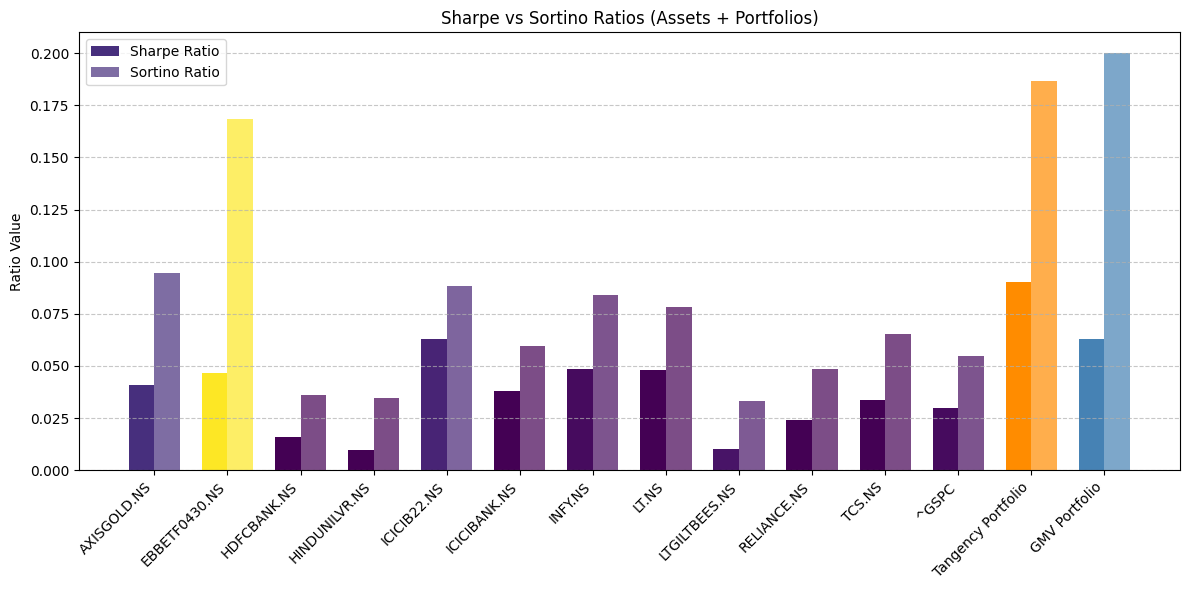

In [7]:
# --- Step 7: Sharpe vs Sortino Bar Chart with Weight-based Colors ---

# Calculate average weights across Tangency and GMV for colormap scaling
weights_df = pd.DataFrame({
    "Tangency": pd.Series(w_tang),
    "GMV": pd.Series(w_gmv)
}).fillna(0)
weights_df["AvgWeight"] = weights_df.mean(axis=1)

# Normalize weights for colormap (0 → 1 scale)
norm_weights = weights_df["AvgWeight"] / weights_df["AvgWeight"].max()

# Assign colors for assets
cmap = plt.cm.viridis
asset_colors = {asset: cmap(norm_weights.get(asset, 0)) for asset in results_df.index}

# Force Tangency/GMV portfolios into neutral colors (gray tones)
asset_colors["Tangency Portfolio"] = "darkorange"
asset_colors["GMV Portfolio"] = "steelblue"

# Plot side-by-side bar chart
x = np.arange(len(results_df.index))  # positions
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, results_df["Sharpe Ratio"], width,
               label="Sharpe Ratio",
               color=[asset_colors[a] for a in results_df.index])
bars2 = ax.bar(x + width/2, results_df["Sortino Ratio"], width,
               label="Sortino Ratio",
               color=[asset_colors[a] for a in results_df.index],
               alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha="right")
ax.set_ylabel("Ratio Value")
ax.set_title("Sharpe vs Sortino Ratios (Assets + Portfolios)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# Structured Analysis & Interpretation of Sharpe vs Sortino Ratios  

Below is a structured interpretation of the scatter plot and bar chart for **Sharpe and Sortino Ratios**, comparing individual assets with the GMV and Tangency Portfolios.  

---

## 1. Distribution of Sharpe vs Sortino Ratios (Scatter Plot)  

- **Portfolios vs. Assets**  
  - **Tangency Portfolio**: Sharpe ~0.09, Sortino ~0.19  
  - **GMV Portfolio**: Sharpe ~0.06, Sortino ~0.20  
  → Both portfolios dominate individual assets on downside-adjusted performance.  

- **Clustering of Assets**  
  - Assets mostly cluster in the **lower-left quadrant**:  
    - Sharpe between **0.01–0.06**  
    - Sortino between **0.03–0.17**  
  - **EBBETF0430.NS (Bharat Bond ETF)**: Standout case — Sharpe = 0.046, Sortino = 0.168 (low downside risk).  
  - **AXISGOLD.NS, ICICIB22.NS, INFY.NS, LT.NS**: Mid-cluster, showing balanced risk-adjusted performance.  
  - **LTGILTBEES.NS, HINDUNILVR.NS, HDFCBANK.NS, RELIANCE.NS**: Weak on both ratios.  

- **Observation**:  
  - Sharpe ratios show **compressed spread** (0.01–0.09).  
  - Sortino ratios show **wider spread** (0.03–0.20).  
  - GMV portfolio looks mediocre on Sharpe but **leads under Sortino**, reflecting low downside exposure.  

---

## 2. Comparison in the Bar Chart (Side-by-Side)  

- **Tangency Portfolio**  
  - Highest Sharpe ratio among all portfolios/assets.  
  - Strong Sortino, though slightly below GMV.  
  → Optimized for efficiency, but not purely downside protection.  

- **GMV Portfolio**  
  - Modest Sharpe (~0.063), weaker than Tangency.  
  - Best Sortino (~0.200).  
  → Most downside-resilient, suitable for risk-averse investors.  

- **Fixed Income & Gold ETFs (EBBETF0430, AXISGOLD)**  
  - Sharpe appears unimpressive.  
  - Sortino values show strong **downside protection**.  
  - EBBETF0430 especially demonstrates asymmetric upside with little downside.  

- **Equity-heavy assets (INFY, LT, ICICIB22)**  
  - Moderate Sharpe and Sortino values.  
  - More balanced performance, but limited downside resilience compared to bonds/gold.  

- **Laggards (HINDUNILVR, LTGILTBEES, HDFCBANK, RELIANCE)**  
  - Weak on both Sharpe & Sortino.  
  - Even downside filtering does not improve attractiveness.  

- **Takeaway from Bar Chart**:  
  - **Sharpe** favors Tangency.  
  - **Sortino** reshuffles rankings, favoring GMV and defensive assets (debt, gold).  

---

## 3. Key Interpretations  

- **Portfolio Selection**  
  - Goal = Maximize efficiency → **Tangency Portfolio** (max Sharpe).  
  - Goal = Minimize downside pain → **GMV Portfolio** (max Sortino).  

- **Asset Screening**  
  - **Winners under Sortino**: Debt & gold ETFs (EBBETF0430, AXISGOLD).  
  - **Consistently unattractive**: Aggressive equities (RELIANCE, HDFCBANK, HINDUNILVR).  

- **Distributional Insight**  
  - Sharpe compresses differences → many assets appear similar.  
  - Sortino spreads results → highlights asymmetry in risk.  
  - This proves downside-focused metrics are more **insightful for portfolio robustness**.  


# Concluding Analysis  

## Tangency vs GMV Portfolios  

- **Tangency Portfolio**  
  - Best performer by **Sharpe Ratio (0.09)** → optimized for overall efficiency.  
  - Suitable for **growth-oriented investors** willing to accept volatility.  

- **GMV Portfolio**  
  - Leads on **Sortino Ratio (0.20)** → superior downside protection and resilience.  
  - Suitable for **conservative, risk-averse investors** prioritizing safety.  

👉 Classic trade-off: Tangency = efficiency; GMV = protection.  

---

## Individual Assets  

- **Debt & Gold ETFs** (EBBETF0430, AXISGOLD, ICICIB22):  
  - Improved significantly under Sortino → strong downside risk protection.  

- **Equities (INFY, LT, TCS):**  
  - Middle ground performers.  
  - Sortino ratios reveal they still carry downside exposure.  

- **Underperformers (HDFCBANK, HINDUNILVR, RELIANCE, LTGILTBEES):**  
  - Weak on both Sharpe & Sortino.  
  - Poor risk-adjusted returns and limited resilience.  

---

## Metric Distribution  

- **Sharpe Ratios:** Compressed range (0.01–0.09) → assets appear more similar.  
- **Sortino Ratios:** Wider range (0.03–0.20) → highlights downside differences.  
- **Implication:** Downside-focused metrics (Sortino) are essential for stress-testing portfolios and identifying robust strategies.  

---

## 🚀 Next Steps  

### Sharpe-to-Sortino Improvement Metric  
- Screen assets prior to including in the potfolio universe by computing **Sortino / Sharpe per asset** and select assets based on risk/return profile and exclude those which doesn't align with the asset profile for the given investment strategy: Set a rule like “exclude assets with negative Sharpe and/or Sortino upfront.”

      Ratio > 1 → Asset benefits a lot from downside filtering (e.g., bonds, gold ETFs, defensive equities).

      Ratio ≈ 1 → Asset’s upside/downside volatility are balanced (e.g., stable blue-chips).

      Ratio < 1 → Asset looks worse on downside-adjusted returns (red flag for strategy fit).

      And a well researched portfolio can also benefit by including high
      volatile with high potential for growth, whose histrical ratio is less
      than 1 however expert information about future growth makes those assets
      prime candidate for inclusion in the portfilio(This would be a very
      strategic portfolio universe)

- Strategy Dependence:
  * For conservative portfolios → prioritize assets with high Sortino/Sharpe improvement.

  * For growth portfolios → Sharpe alone may still be the primary filter, with Sortino/Sharpe used as a secondary screen.

    **Suggested Workflow**:

    Step 1: Compute Sharpe & Sortino for all assets.

    Step 2: Exclude assets with negative Sharpe OR Sortino.

    Step 3: Compute Sortino/Sharpe ratio for the rest.

    Step 4: Rank assets by this ratio → shows who benefits most from downside filtering.

    Step 5: Build portfolio universe accordingly (e.g., keep top 50% by ratio).

### Scenario Analysis  
- Run tests across **bull, bear, and sideways regimes**.  
- See if GMV consistently leads on Sortino or if Tangency gains resilience in expansions.  

### Factor Attribution  
- Break down GMV & Tangency into **equity, debt, gold, global exposures**.  
- Identify which classes drive the difference in Sharpe vs Sortino.  

### Dynamic Portfolio Strategy  
- **Switching framework:**  
  - Use Tangency (Sharpe-optimal) in stable/expansion phases.  
  - Use GMV (Sortino-optimal) in volatility spikes or risk-off phases.  

---

## ⚖️ Bottom Line  

- **Absolute Efficiency → Tangency Portfolio wins.**  
- **Downside Protection → GMV Portfolio + defensive ETFs (Bharat Bond, Gold) shine.**  
- **Best Strategy → Adaptive approach:**  
  - Blend or switch between Tangency and GMV depending on market regime.  
